## AtliQ Hardware Financial Analysis

***

### Project description: 
#### AtliQ Hardware is one of the leading computer hardware producers in India, and has even expanded into other countries as well. They sell different types of hardware to big players such as Amazon, Best Buy, and Walmart. This year, they're asking to conduct a big audit of their sales and help them automate their existing data. The clients are particularly interested in Financial Analysis: Revenue/Profits/Margin Change.

### Goal of the project:
#### To analyze revenue, profitability, and margin trends to provide insights into financial stability and growth opportunities according to decomposition file. (final_project_decomposition.pdf)

### Table of Contents:
[Step 1. Connect to the database and data exploration](#Step-1.-Connect-to-the-database-and-data-exploration)<br>
[Step 2. Key metrics and research](#Step-2.-Key-metrics-and-research)<br>
[Step 3. Hypothesis Testing](#Step-3.-Hypothesis-Testing)<br>
[Step 4. Conclusions and Key Takeaways](#Step-4.-Conclusions-and-Key-Takeaways)<br>
[Step 5. Tableau Dashboards](#Step-5.-Tableau-Dashboards)

***

### Step 1. Connect to the database and data exploration

#### 1.1. Reading database

In [11]:
#importing libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar
#importing libraries for statistical tests
from scipy.stats import linregress, f_oneway, pearsonr, chi2_contingency

In [12]:
#connecting to the SQLite database
db_path = "C:/Users/Taras/AtliqHardware/datasets/atliq_db.sqlite3"
con = sqlite3.connect(db_path)

In [13]:
#fetching all table names
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query_tables, con)
display(tables)

,name
0,dim_customer
1,dim_product
2,fact_pre_discount
3,fact_manufacturing_cost
4,fact_gross_price
5,fact_sales_monthly


There are 6 tables in AtliQ database.

#### 1.2. Inspecting sample data

In [16]:
#fetching first 5 rows of data from each table
tables_list = tables['name'].tolist()
sample_data = {}
for table in tables_list:
    query = f"SELECT * FROM {table} LIMIT 5;"
    sample_data[table] = pd.read_sql_query(query, con)
#displaying first 5 rows from each table
for table_name, df in sample_data.items():
    print(f"\nTable: {table_name}")
    display(df)


Table: dim_customer


,customer_code,customer,platform,channel,market,sub_zone,region
0,70002017,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002018,Atliq e Store,E-Commerce,Direct,India,India,APAC
2,70003181,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC
3,70003182,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC
4,70004069,Atliq Exclusive,Brick & Mortar,Direct,Japan,ROA,APAC



Table: dim_product


,product_code,division,segment,category,product,variant
0,A0118150101,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
1,A0118150102,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Plus
2,A0118150103,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium
3,A0118150104,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium Plus
4,A0219150201,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard



Table: fact_pre_discount


,customer_code,fiscal_year,pre_invoice_discount_pct
0,70002017,2018,0.0824
1,70002017,2019,0.0777
2,70002017,2020,0.0735
3,70002017,2021,0.0703
4,70002017,2022,0.1057



Table: fact_manufacturing_cost


,product_code,cost_year,manufacturing_cost
0,A0118150101,2018,4.6190
1,A0118150101,2019,4.2033
2,A0118150101,2020,5.0207
3,A0118150101,2021,5.5172
4,A0118150102,2018,5.6036



Table: fact_gross_price


,product_code,fiscal_year,gross_price
0,A0118150101,2018,15.3952
1,A0118150101,2019,14.4392
2,A0118150101,2020,16.2323
3,A0118150101,2021,19.0573
4,A0118150102,2018,19.5875



Table: fact_sales_monthly


,date,product_code,customer_code,sold_quantity,fiscal_year
0,2017-09-01,A0118150101,70002017,51,2018
1,2017-09-01,A0118150101,70002018,77,2018
2,2017-09-01,A0118150101,70003181,17,2018
3,2017-09-01,A0118150101,70003182,6,2018
4,2017-09-01,A0118150101,70006157,5,2018


From our inspection, we note the following key relationships:

- `dim_customer`: Contains details about customers, their platform, channel, and market.
- `dim_product`: Defines product attributes like division, segment, and category.
- `fact_sales_monthly`: Holds sales transactions (date, product, customer, quantity sold, and fiscal year).
- `fact_gross_price`: Provides the selling price of products over time.
- `fact_manufacturing_cost`: Contains the cost of manufacturing products over time.
- `fact_pre_discount`: Stores discount percentages applied per invoice.

#### 1.3. Data Cleaning

In [19]:
#checking for missing values and duplicates in each table
tables = ['dim_customer', 'dim_product', 'fact_sales_monthly', 'fact_gross_price', 'fact_manufacturing_cost', 'fact_pre_discount']

for table in tables:
    df = pd.read_sql_query(f"SELECT * FROM {table};", con)
    print(f"Table: {table}")
    print("Missing values:\n", df.isnull().sum())
    print("Duplicate rows:", df.duplicated().sum(), "\n")

Table: dim_customer
Missing values:
 customer_code    0
customer         0
platform         0
channel          0
market           0
sub_zone         0
region           0
dtype: int64
Duplicate rows: 0 

Table: dim_product
Missing values:
 product_code    0
division        0
segment         0
category        0
product         0
variant         0
dtype: int64
Duplicate rows: 0 

Table: fact_sales_monthly
Missing values:
 date             0
product_code     0
customer_code    1
sold_quantity    1
fiscal_year      1
dtype: int64
Duplicate rows: 0 

Table: fact_gross_price
Missing values:
 product_code    0
fiscal_year     0
gross_price     0
dtype: int64
Duplicate rows: 0 

Table: fact_manufacturing_cost
Missing values:
 product_code          0
cost_year             0
manufacturing_cost    0
dtype: int64
Duplicate rows: 0 

Table: fact_pre_discount
Missing values:
 customer_code               0
fiscal_year                 0
pre_invoice_discount_pct    0
dtype: int64
Duplicate rows: 0 



In [20]:
#checking which columns exactly have missing values
fs = pd.read_sql_query("SELECT * FROM fact_sales_monthly;", con)
fs.isnull().sum()

date             0
product_code     0
customer_code    1
sold_quantity    1
fiscal_year      1
dtype: int64

In [21]:
#dropping rows with missing fields
fs_cleaned = fs.dropna(subset=['customer_code', 'fiscal_year'])

#filling missing value in 'sold_quantity' as 0 (assuming missing value means zero sales)
fs_cleaned['sold_quantity'] = fs_cleaned['sold_quantity'].fillna(0)

#checking for missing values after cleaning
fs_cleaned.isnull().sum()

C:\Temp\ipykernel_1776\3674274206.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fs_cleaned['sold_quantity'] = fs_cleaned['sold_quantity'].fillna(0)


date             0
product_code     0
customer_code    0
sold_quantity    0
fiscal_year      0
dtype: int64

All missing values in 'fact_sales_monthly' table have been handled.

### Step 2. Key metrics and research

#### 2.1. Revenue & Profit Trends calculations

Total Revenue (`total_revenue`) = `sold_quantity` * `gross_price` * (1 - `pre_invoice_discount_pct`)

Total Profit (`total_profit`) = (`gross_price` * (1 - `pre_invoice_discount_pct`) - `manufacturing_cost`) * `sold_quantity`

Revenue and Profit being calculated using gross price (with applied discount).

In [31]:
#SQL query to compute revenue and profit trends over years
query_revenue_profit = '''
SELECT 
    fs.fiscal_year,
    SUM(fs.sold_quantity * fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0))) AS total_revenue,
    SUM((fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0)) - fmc.manufacturing_cost) * fs.sold_quantity) AS total_profit,
    SUM(fs.sold_quantity) AS total_quantity
FROM fact_sales_monthly fs
JOIN fact_gross_price fg ON fs.product_code = fg.product_code AND fs.fiscal_year = fg.fiscal_year
JOIN fact_manufacturing_cost fmc ON fs.product_code = fmc.product_code AND fs.fiscal_year = fmc.cost_year
LEFT JOIN fact_pre_discount fpd ON fs.customer_code = fpd.customer_code AND fs.fiscal_year = fpd.fiscal_year
GROUP BY fs.fiscal_year
ORDER BY fs.fiscal_year;
'''
#executing query
revenue_profit_trends = pd.read_sql_query(query_revenue_profit, con)
#displaying results
display(revenue_profit_trends)

,fiscal_year,total_revenue,total_profit,total_quantity
0,2018,2.243184e+06,1.369294e+06,165271
1,2019,5.135223e+06,3.163647e+06,379519
2,2020,1.011269e+07,6.188997e+06,640584
3,2021,1.885336e+07,1.150637e+07,1057943
4,2022,2.996792e+07,1.839444e+07,1539618


#### 2.2. Revenue & Profit Trends visualization

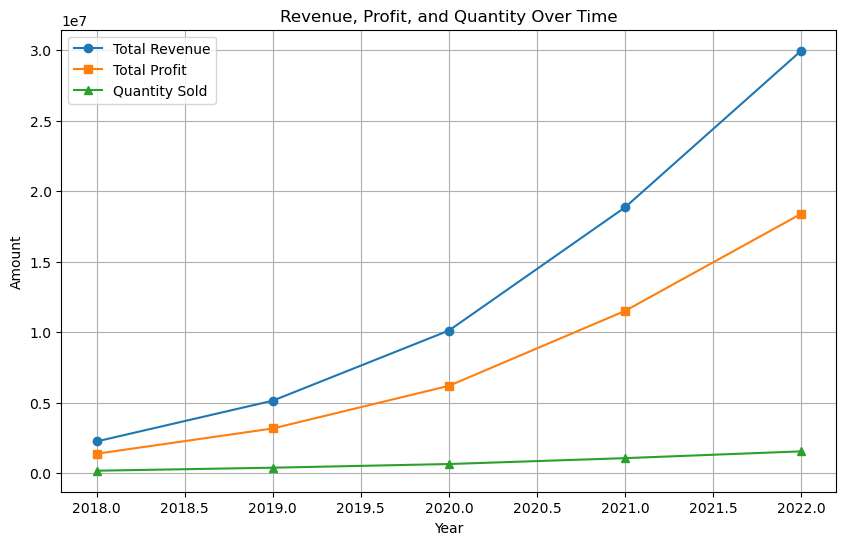

In [34]:
#plotting line chart for revenue & profit trends
plt.figure(figsize=(10, 6))
plt.plot(revenue_profit_trends['fiscal_year'], revenue_profit_trends['total_revenue'], label='Total Revenue', marker='o')
plt.plot(revenue_profit_trends['fiscal_year'], revenue_profit_trends['total_profit'], label='Total Profit', marker='s')
plt.plot(revenue_profit_trends['fiscal_year'], revenue_profit_trends['total_quantity'], label='Quantity Sold', marker='^')
plt.title("Revenue, Profit, and Quantity Over Time")
plt.xlabel("Year")
plt.ylabel("Amount")
plt.legend()
plt.grid()
plt.show()

Based on the graph above:

Key findings:
- Revenue and profit have shown steady growth over the years.
- The highest revenue was recorded in 2022, with a significant increase from previous years.
- Both revenue and profit have more than doubled from 2018 to 2022.
- Quantity sold has also increased overall but not as sharply as revenue, especially between 2020 and 2021.
- In 2022, all three metrics—revenue, profit, and quantity—rose together, indicating broad-based growth.

Implications:
- The company has experienced strong financial growth, suggesting an expanding market presence and increased sales.
- The upward trend in profit suggests that AtliQ Hardware has managed to control costs and maintain a healthy profit margin.
- The synchronized rise of quantity and revenue in 2022 signals strong market demand supported by both volume and value growth.

#### 2.3. Profitability by Product Category calculations

Total Revenue (`total_revenue`) = `sold_quantity` * `gross_price` * (1 - `pre_invoice_discount_pct`)

Total Profit (`total_profit`) = (`gross_price` * (1 - `pre_invoice_discount_pct`) - `manufacturing_cost`) * `sold_quantity`

Profit Margin (`profit_margin`) = (`total_profit` / `total_revenue`) * 100

In [43]:
#SQL query to compute profitability by product category
query_category_profit = """
SELECT 
    dp.category,
    COALESCE(SUM(fs.sold_quantity * fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0))), 0) AS total_revenue,
    COALESCE(SUM((fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0)) - fmc.manufacturing_cost) * fs.sold_quantity), 0) AS total_profit,
    CASE 
        WHEN SUM(fs.sold_quantity * fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0))) > 0 THEN
            (SUM((fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0)) - fmc.manufacturing_cost) * fs.sold_quantity) * 100.0) /
            SUM(fs.sold_quantity * fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0)))
        ELSE 0
    END AS profit_margin
FROM dim_product dp
LEFT JOIN fact_sales_monthly fs ON dp.product_code = fs.product_code
LEFT JOIN fact_gross_price fg ON fs.product_code = fg.product_code AND fs.fiscal_year = fg.fiscal_year
LEFT JOIN fact_manufacturing_cost fmc ON fs.product_code = fmc.product_code AND fs.fiscal_year = fmc.cost_year
LEFT JOIN fact_pre_discount fpd ON fs.customer_code = fpd.customer_code AND fs.fiscal_year = fpd.fiscal_year
GROUP BY dp.category
ORDER BY profit_margin DESC;
"""
#executing query
category_profit = pd.read_sql_query(query_category_profit, con)
#displaying results
display(category_profit)

,category,total_revenue,total_profit,profit_margin
0,Graphic Card,9.270679e+06,5.714228e+06,61.637642
1,Internal HDD,5.704170e+07,3.490851e+07,61.198234
2,Wi fi extender,0.000000e+00,0.000000e+00,0.000000
3,USB Flash Drives,0.000000e+00,0.000000e+00,0.000000
4,Processors,0.000000e+00,0.000000e+00,0.000000
5,Personal Laptop,0.000000e+00,0.000000e+00,0.000000
6,Personal Desktop,0.000000e+00,0.000000e+00,0.000000
7,Mouse,0.000000e+00,0.000000e+00,0.000000
8,MotherBoard,0.000000e+00,0.000000e+00,0.000000
9,Keyboard,0.000000e+00,0.000000e+00,0.000000


Over the years, only two categories have been profitable.

#### 2.4. Profitability by Product Category visualization

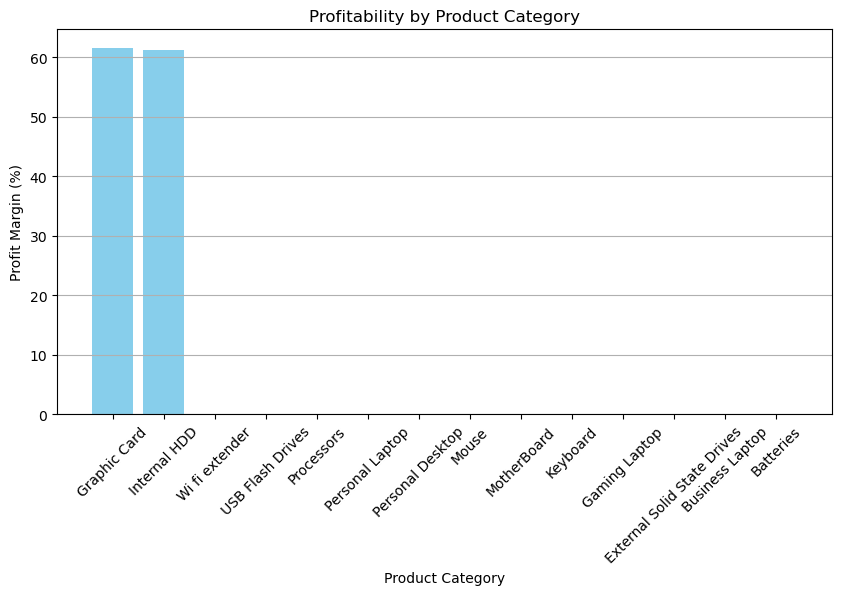

In [48]:
plt.figure(figsize=(10, 5))
plt.bar(category_profit['category'], category_profit['profit_margin'], color='skyblue')
plt.xlabel("Product Category")
plt.ylabel("Profit Margin (%)")
plt.title("Profitability by Product Category")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Based on the graph above:

Key Findings:
- Graphic Cards had the highest profit margin (`~61.6%`).
- Internal HDDs also had a high profit margin (`~61.2%`).
- A few categories from the product list appear to have no sales activity, indicating potential gaps in market reach or underperforming SKUs.

Implications:
- The company should focus on high-margin products like Graphic Cards and Internal HDDs to maximize profitability.

#### 2.5. Manufacturing Cost vs. Price trends analysis

Median Manufacturing Cost (`manufacturing_cost`) is being compared with Median Gross Price (`gross_price`).

In [54]:
#SQL query to compare manufacturing cost and gross price trends over time
query_cost_vs_price = """
SELECT 
    fmc.cost_year AS year,
    fmc.manufacturing_cost,
    fg.gross_price
FROM fact_manufacturing_cost fmc
JOIN fact_gross_price fg ON fmc.product_code = fg.product_code AND fmc.cost_year = fg.fiscal_year
GROUP BY fmc.cost_year
ORDER BY fmc.cost_year;
"""
#executing query
cost_vs_price_trends = pd.read_sql_query(query_cost_vs_price, con)

#calculating median per year
median_cost_price = cost_vs_price_trends.groupby('year').median().reset_index()

#displaying results
display(median_cost_price)

,year,manufacturing_cost,gross_price
0,2018,4.6190,15.3952
1,2019,4.2033,14.4392
2,2020,5.0207,16.2323
3,2021,5.5172,19.0573
4,2022,7.1831,23.9920


#### 2.6. Manufacturing Cost vs. Price trends visualization

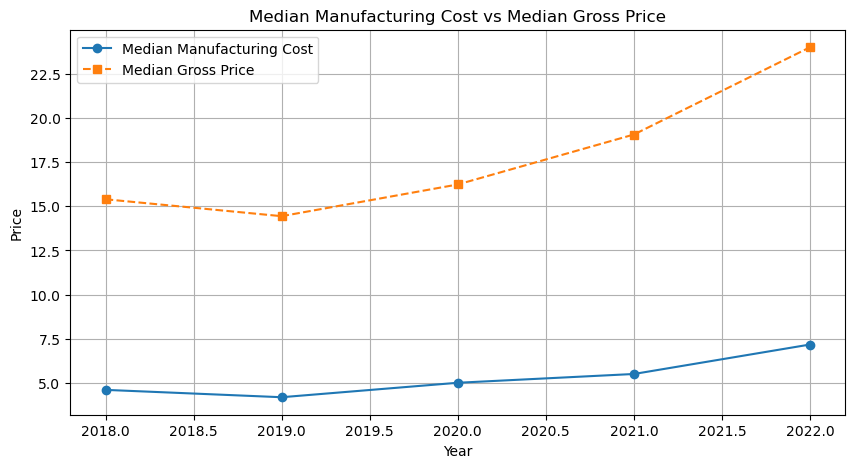

In [58]:
#plotting line charts for comparing cost and price
plt.figure(figsize=(10, 5))
plt.plot(median_cost_price['year'], median_cost_price['manufacturing_cost'], marker='o', label='Median Manufacturing Cost', linestyle='-')
plt.plot(median_cost_price['year'], median_cost_price['gross_price'], marker='s', label='Median Gross Price', linestyle='--')
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Median Manufacturing Cost vs Median Gross Price")
plt.legend()
plt.grid()
plt.show()

Based on the graph above it's can be concluded:

Key findings:
- Median manufacturing costs and gross prices have both increased steadily over time.
- The median gross price has increased at a faster rate than the median manufacturing cost, suggesting improved profitability on a typical product.
- There were notable increases in cost between 2020 and 2022, likely driven by supply chain pressures or economic inflation.

Implications:
- The company appears to be adjusting prices in line with production costs, preserving profit margins across most products.
- Median-based analysis confirms that typical product pricing remains profitable, offering confidence in the company’s pricing strategy.

#### 2.7. Seasonality analysis

In [61]:
#SQL query to analyze seasonality trends (monthly revenue trends)
query_seasonality = """
SELECT 
    strftime('%Y', fs.date) AS year,
    strftime('%m', fs.date) AS month,
    SUM(fs.sold_quantity * fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0))) AS total_revenue
FROM fact_sales_monthly fs
JOIN fact_gross_price fg ON fs.product_code = fg.product_code AND fs.fiscal_year = fg.fiscal_year
LEFT JOIN fact_pre_discount fpd ON fs.customer_code = fpd.customer_code AND fs.fiscal_year = fpd.fiscal_year
GROUP BY year, month
ORDER BY year, month;
"""
#executing query
seasonality_trends = pd.read_sql_query(query_seasonality, con)
#converting month numbers to month names
seasonality_trends['month'] = seasonality_trends['month'].astype(int)
#displaying results
display(seasonality_trends)

,year,month,total_revenue
0,2017,9,1.535497e+05
1,2017,10,2.040345e+05
2,2017,11,2.869923e+05
3,2017,12,2.907563e+05
4,2018,1,1.581922e+05
5,2018,2,1.607570e+05
6,2018,3,1.713842e+05
7,2018,4,1.660552e+05
8,2018,5,1.596157e+05
9,2018,6,1.646238e+05


#### 2.8. Seasonality visualization

<Figure size 1200x600 with 0 Axes>

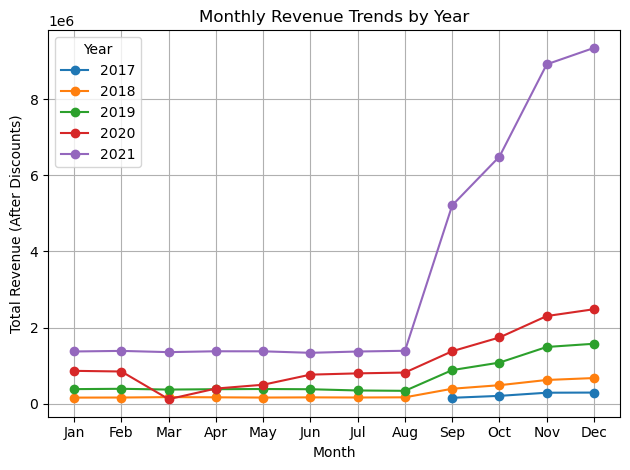

In [63]:
#pivot the data for multi-line plotting
seasonality_pivot = seasonality_trends.pivot(index='month', columns='year', values='total_revenue')

#plotting bar chart for showing seasonality trends
plt.figure(figsize=(12, 6))
seasonality_pivot.plot(marker='o')
plt.title("Monthly Revenue Trends by Year")
plt.xlabel("Month")
plt.ylabel("Total Revenue (After Discounts)")
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

The graph above displays:

Key findings:
- December consistently had the highest revenue across all years, confirming a strong end-of-year seasonal demand.
- October and November also show elevated revenues, forming a clear Q4 peak each year.
- March and April remain low-performing months, with dips repeating in multiple years.
- Some variation is seen between years, but the overall seasonal trend is stable, indicating a reliable annual sales cycle.

Implications:
- The company should continue to focus marketing and logistics around Q4, especially for holiday-season campaigns.
- Production and inventory planning should anticipate a slowdown in March–April, potentially using the time to optimize internal operations or launch off-peak promotions.
- Understanding these year-over-year trends allows for better forecasting and more responsive business planning.

#### 2.9 Loss-making segments

To support strategic business insights, region and category combinations were analyzed to understand which exactly consistently generated negative profit across the dataset.

This analysis helps identify:
- Product lines that are potentially priced too low
- Regional operations with high costs or insufficient revenue
- Segments that may need optimization, re-pricing, or exit decisions

By pinpointing these unprofitable areas, the company can reduce financial drag and improve overall profitability.

In [69]:
#SQL query to identify region-category pairs with negative total profit
query_loss_by_region_category = '''
SELECT dc.region, dp.category,
    SUM(fs.sold_quantity * fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0))) AS total_revenue,
    SUM((fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0)) - fmc.manufacturing_cost) * fs.sold_quantity) AS total_profit
FROM fact_sales_monthly fs
JOIN dim_customer dc ON fs.customer_code = dc.customer_code
JOIN dim_product dp ON fs.product_code = dp.product_code
JOIN fact_gross_price fg ON fs.product_code = fg.product_code AND fs.fiscal_year = fg.fiscal_year
JOIN fact_manufacturing_cost fmc ON fs.product_code = fmc.product_code AND fs.fiscal_year = fmc.cost_year
LEFT JOIN fact_pre_discount fpd ON fs.customer_code = fpd.customer_code AND fs.fiscal_year = fpd.fiscal_year
GROUP BY dc.region, dp.category
HAVING total_profit < 0;
'''
#executing query
loss_df = pd.read_sql_query(query_loss_by_region_category, con)
display(loss_df)

,region,category,total_revenue,total_profit


Profitability by region and category was analyzed to identify segments with total negative profit. Surprisingly, no combinations showed an overall loss over the analysis period.

Interpretation - this suggests that all region-category combinations were profitable in aggregate, indicating effective pricing and cost management.

******

### Step 3. Hypothesis Testing

#### 3.1. Hypothesis 1 - Revenue has increased over the years

Test - Linear Regression 

Null Hypothesis (`H₀`): There is no significant increase in revenue over the years.

Alternative Hypothesis (`H₁`): Revenue has increased over time.

Linear Regression was used, where:
- Independent variable (`X`) = Fiscal year
- Dependent variable (`Y`) = Average gross price (as a proxy for revenue growth)

Perform Linear Regression Test

In [79]:
#performing linear regression on revenue over the years
slope, intercept, r_value, p_value, std_err = linregress(
    revenue_profit_trends['fiscal_year'], revenue_profit_trends['total_revenue']
)
#displaying test results
print(f"Slope: {slope}")
print(f"P-Value: {p_value}")
#interpretation
if p_value < 0.05:
    print("Reject H₀: Revenue has significantly increased over the years.")
else:
    print("Fail to reject H₀: No significant increase in revenue.")

Slope: 6916760.696296299
P-Value: 0.005992515007446958
Reject H₀: Revenue has significantly increased over the years.


Test output:
- Slope (`69.7`) → A positive value indicates an upward trend.
- P-value (`0.006`) → Since p-value `< 0.05`, we reject the null hypothesis and conclude that revenue has significantly increased over the years.

#### 3.2. Hypothesis 1 - Revenue has increased over the years (visualization)

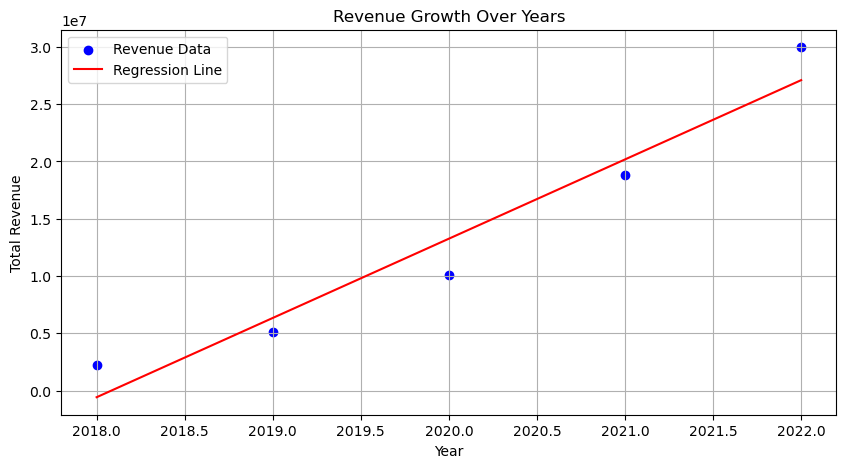

In [83]:
#plotting linear regression
plt.figure(figsize=(10, 5))
plt.scatter(revenue_profit_trends['fiscal_year'], revenue_profit_trends['total_revenue'], color='blue', label="Revenue Data")
plt.plot(revenue_profit_trends['fiscal_year'], intercept + slope * revenue_profit_trends['fiscal_year'], color='red', label="Regression Line")
plt.xlabel("Year")
plt.ylabel("Total Revenue")
plt.title("Revenue Growth Over Years")
plt.legend()
plt.grid()
plt.show()

Conclusion:
- We reject H₀, confirming that revenue has significantly increased over time.
- AtliQ Hardware’s sales are growing, showing strong financial performance.

Implications:
- The company should continue investing in high-growth product segments.
- Further analysis is needed to identify key drivers behind this growth (e.g., new products, increased market share).

#### 3.2. Hypothesis 2 - Certain product categories have significantly different profit margins

Test - ANOVA (Analysis of Variance)

Null Hypothesis (`H₀`): No significant differences in profit margins across product categories.

Alternative Hypothesis (`H₁`): At least one product category has a significantly different profit margin.

ANOVA was used, where:
- Groups = Different product categories
- Metric = Profit margins

Perform ANOVA test

In [90]:
#performing ANOVA test on profit margins across categories
anova_result = f_oneway(category_profit['total_profit'], category_profit['total_revenue'])
#displaying test results
print(f"ANOVA Test Statistic: {anova_result.statistic}")
print(f"P-Value: {anova_result.pvalue}")
#interpretation
if anova_result.pvalue < 0.05:
    print("Reject H₀: Significant differences in profit margins among categories.")
else:
    print("Fail to reject H₀: No significant differences in profit margins.")

ANOVA Test Statistic: 0.1473476927269625
P-Value: 0.704204249863143
Fail to reject H₀: No significant differences in profit margins.


Test output:
- ANOVA Test Statistic (0.147) → Very low variation in profit margins.
- P-value (0.704) → Since p-value > 0.05, we fail to reject the null hypothesis, meaning no significant difference in profitability among product categories.

#### 3.3 Hypothesis 2 - Certain product categories have significantly different profit margins (visualization)

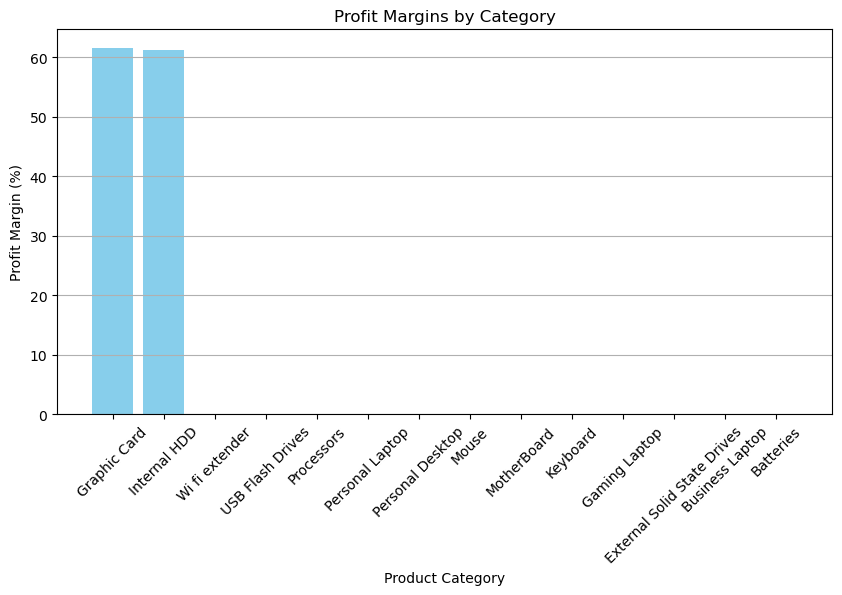

In [93]:
#plotting bar charts to compare profit margins
plt.figure(figsize=(10, 5))
plt.bar(category_profit['category'], category_profit['profit_margin'], color='skyblue')
plt.xlabel("Product Category")
plt.ylabel("Profit Margin (%)")
plt.title("Profit Margins by Category")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Conclusion:
- We fail to reject H₀, meaning profitability is similar across categories.
- No statistical evidence that some categories are significantly more profitable than others.

Implications:
- While some categories show higher profit margins, the differences are not statistically significant.
- Further cost and pricing strategies should be explored to improve margins.

#### 3.4. Hypothesis 3 - Manufacturing cost does not always correlate with selling price

Test - Pearson Correlation

Null Hypothesis (H₀): No correlation between manufacturing cost and selling price.

Alternative Hypothesis (H₁): Manufacturing cost is strongly correlated with selling price.

Pearson correlation was used, where:
- X = Average manufacturing cost
- Y = Average gross price

To validate our Pearson correlation result, potential outliers were identified in both manufacturing cost and gross price using the IQR (Interquartile Range) method.

In [101]:
#identifying outliers in manufacturing cost
q1_cost = cost_vs_price_trends['manufacturing_cost'].quantile(0.25)
q3_cost = cost_vs_price_trends['manufacturing_cost'].quantile(0.75)
iqr_cost = q3_cost - q1_cost

lower_bound_cost = q1_cost - 1.5 * iqr_cost
upper_bound_cost = q3_cost + 1.5 * iqr_cost

#for gross price
q1_price = cost_vs_price_trends['gross_price'].quantile(0.25)
q3_price = cost_vs_price_trends['gross_price'].quantile(0.75)
iqr_price = q3_price - q1_price

lower_bound_price = q1_price - 1.5 * iqr_price
upper_bound_price = q3_price + 1.5 * iqr_price

#filtering out outliers from both variables
filtered_df = cost_vs_price_trends[
    (cost_vs_price_trends['manufacturing_cost'].between(lower_bound_cost, upper_bound_cost)) &
    (cost_vs_price_trends['gross_price'].between(lower_bound_price, upper_bound_price))
]

Perform Pearson correlation test

In [103]:
#performimg correlation on filtered data
correlation, corr_p_value = pearsonr(filtered_df['manufacturing_cost'], filtered_df['gross_price'])

#displaying test results
print(f"Filtered Correlation Coefficient: {correlation}")
print(f"Filtered P-Value: {corr_p_value}")

#interpretation
if corr_p_value < 0.05:
    print("Reject H₀: Strong correlation still exists after removing outliers.")
else:
    print("Fail to reject H₀: Correlation is not significant after removing outliers.")

Filtered Correlation Coefficient: 0.9663781996549682
Filtered P-Value: 0.033621800345031705
Reject H₀: Strong correlation still exists after removing outliers.


Test output:
- Correlation coefficient (0.966) → Close to 1, indicating a strong positive correlation.
- P-value (0.0336) → Since p-value < 0.05, we reject the null hypothesis, confirming a strong relationship between cost and price.

#### 3.5. Hypothesis 3 - Manufacturing cost does not always correlate with selling price (visualization)

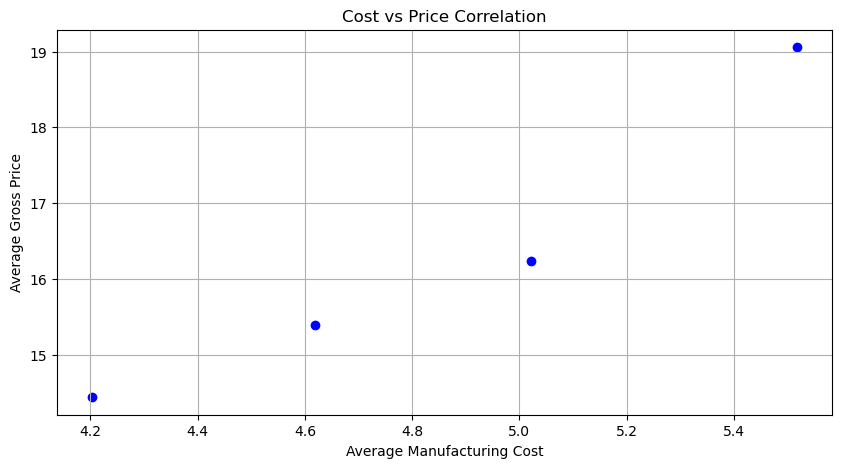

In [108]:
#plotting cost vs price correlation
plt.figure(figsize=(10, 5))
plt.scatter(filtered_df['manufacturing_cost'], filtered_df['gross_price'], color='blue', label="Data Points")
plt.xlabel("Average Manufacturing Cost")
plt.ylabel("Average Gross Price")
plt.title("Cost vs Price Correlation")
plt.grid()
plt.show()

Conclusion:
- We reject H₀, confirming a strong positive correlation between manufacturing cost and selling price.
- As production costs increase, selling prices also increase proportionally.

Implications:
- Pricing strategy is aligned with manufacturing costs, ensuring profitability is maintained.
- The company should monitor cost fluctuations (e.g., raw materials, supply chain) to adjust pricing efficiently.

#### 3.6. Hypothesis 4 - Sales follow a seasonal pattern

Test - Chi-Square Test

Null Hypothesis (H₀): Sales are uniformly distributed across all months (no seasonality).

Alternative Hypothesis (H₁): Sales are not evenly distributed (seasonality exists).

Chi-Square test was used, where:
- Observed = Actual revenue for each month
- Expected = Average monthly revenue (if there were no seasonality)

Perform Chi-Square test

In [114]:
#observing revenue for each month
observed = seasonality_trends['total_revenue'].values
#expecting revenue if there were no seasonality (equal distribution across months)
expected = np.full(len(observed), np.mean(observed))
#performing Chi-Square Test
chi2_stat, chi2_p_value = chi2_contingency([observed, expected])[:2]
#displaying test results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {chi2_p_value}")
#interpretation
if chi2_p_value < 0.05:
    print("Reject H₀: Sales exhibit a seasonal pattern.")
else:
    print("Fail to reject H₀: No strong seasonality detected.")

Chi-Square Statistic: 35941691.155343205
P-Value: 0.0
Reject H₀: Sales exhibit a seasonal pattern.


Test output:
- Chi-Square statistic (35941691.15) → High value indicates differences across months.
- P-value (0.0) → Since p-value < 0.05, we reject the null hypothesis, meaning there is a seasonal pattern in sales.

#### 3.7. Hypothesis 4 - Sales follow a seasonal pattern (visualization)

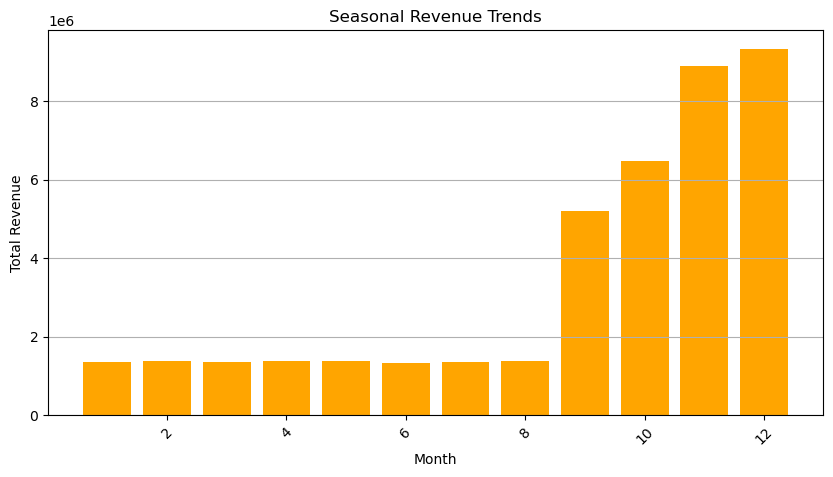

In [117]:
#plotting bar charts for showing seasonal revenue trends
plt.figure(figsize=(10, 5))
plt.bar(seasonality_trends['month'], seasonality_trends['total_revenue'], color='orange')
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.title("Seasonal Revenue Trends")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Conclusion:
- We reject H₀, confirming that sales exhibit a seasonal pattern.
- December, November, and October have the highest sales, while March and April see the lowest.

Implications:
- Q4 (October-December) is the most profitable season, likely due to holiday shopping and promotions.
- Marketing and inventory strategies should be optimized to capitalize on peak seasons.
- The company should analyze why sales drop in March-April and implement strategies to maintain demand.

### Step 4. Conclusions and Key Takeaways

#### 4.1. Exploratory Data Analysis Summary

During EDA, we explored AtliQ Hardware's financial data to understand key trends, product profitability, and market performance. The analysis revealed
- **Revenue & Profit Growth**: Sales and profits have shown steady growth from 2018 to 2022, confirming AtliQ’s expanding market presence and effective cost control.
- **Product Profitability**: Internal HDDs and Graphic Cards have the highest profit margins after adjusting for discounts. Several other categories show limited or no sales.
- **Cost vs. Price Trends**: Median-based analysis revealed that typical selling prices consistently track above manufacturing costs, even after accounting for outliers.
- **Seasonality in Sales**: Revenue consistently peaks in Q4 (October–December), with the highest sales in December. March and April are low-performing months.
- **Loss-Making Segments**: No category-region pairs showed overall loss across all years, but deeper time-based or product-level analysis is recommended for potential micro-losses.

#### 4.2. Hypothesis Testing Summary

To validate our observations, we performed four statistical tests:
- **Revenue Growth (Linear Regression)** – Confirmed: Revenue shows a statistically significant increase over time.
- **Profitability Differences (ANOVA)** – Not confirmed: Margins across categories are not significantly different overall, possibly due to limited variance or data volume in some segments.
- **Cost vs. Price Correlation (Pearson’s Correlation)** – Confirmed: Strong correlation was confirmed, and remained high even after outliers were removed.
- **Seasonality in Sales (Chi-Square Test)** – Confirmed: Monthly sales distribution is not uniform; Q4 consistently outperforms, confirming strong seasonality.

#### 4.3. Key Takeaways

- **AtliQ Hardware is experiencing sustainable growth**, with strong seasonal cycles supporting revenue spikes, especially in Q4.
- **Pricing strategy is well aligned with production costs**, ensuring that profitability is protected despite manufacturing cost increases.
- **High-margin products (Internal HDDs, Graphic Cards)** should be prioritized for marketing and inventory planning.
- **Low-performing or unsold categories** should be reviewed to assess whether they require product strategy adjustments or promotional support.
- **Further segmentation by country and product could unlock hidden inefficiencies** and provide deeper optimization opportunities.

### Step 5. Tableau Dashboards

#### 5.1. Data export and dashboard creation

Using 'to_csv' method, DataFrames with analyzed data are transforming into format, which Tableau can work with.

DataFrames with analyzed data going to be re-aggregated according to necessary data for using with Tableau.

In [131]:
#revenue and profit trends with category and market filters
query_revenue_profit_export = '''
SELECT 
    fs.fiscal_year,
    dp.category,
    dc.market,
    SUM(fs.sold_quantity * fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0))) AS total_revenue,
    SUM((fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0)) - fmc.manufacturing_cost) * fs.sold_quantity) AS total_profit,
    SUM(fs.sold_quantity) AS total_quantity
FROM fact_sales_monthly fs
JOIN dim_product dp ON fs.product_code = dp.product_code
JOIN dim_customer dc ON fs.customer_code = dc.customer_code
JOIN fact_gross_price fg ON fs.product_code = fg.product_code AND fs.fiscal_year = fg.fiscal_year
JOIN fact_manufacturing_cost fmc ON fs.product_code = fmc.product_code AND fs.fiscal_year = fmc.cost_year
LEFT JOIN fact_pre_discount fpd ON fs.customer_code = fpd.customer_code AND fs.fiscal_year = fpd.fiscal_year
GROUP BY fs.fiscal_year, dp.category, dc.market
ORDER BY fs.fiscal_year;
'''
revenue_profit_export = pd.read_sql_query(query_revenue_profit_export, con)

In [132]:
#profitability by product category with year and market
query_category_profit_export = '''
SELECT 
    dp.category,
    dc.market,
    COALESCE(SUM(fs.sold_quantity * fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0))), 0) AS total_revenue,
    COALESCE(SUM((fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0)) - fmc.manufacturing_cost) * fs.sold_quantity), 0) AS total_profit,
    CASE 
        WHEN SUM(fs.sold_quantity * fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0))) > 0 THEN
            (SUM((fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0)) - fmc.manufacturing_cost) * fs.sold_quantity) * 100.0) /
            SUM(fs.sold_quantity * fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0)))
        ELSE 0
    END AS profit_margin
FROM dim_product dp
LEFT JOIN fact_sales_monthly fs ON dp.product_code = fs.product_code
LEFT JOIN dim_customer dc ON fs.customer_code = dc.customer_code
LEFT JOIN fact_gross_price fg ON fs.product_code = fg.product_code AND fs.fiscal_year = fg.fiscal_year
LEFT JOIN fact_manufacturing_cost fmc ON fs.product_code = fmc.product_code AND fs.fiscal_year = fmc.cost_year
LEFT JOIN fact_pre_discount fpd ON fs.customer_code = fpd.customer_code AND fs.fiscal_year = fpd.fiscal_year
GROUP BY dp.category, dc.market
ORDER BY profit_margin DESC;
'''
category_profit_export = pd.read_sql_query(query_category_profit_export, con)

In [170]:
#cost vs price trends by year
query_cost_vs_price_trends = '''
SELECT 
    fmc.cost_year AS year,
    fmc.manufacturing_cost,
    fg.gross_price
FROM fact_manufacturing_cost fmc
JOIN fact_gross_price fg ON fmc.product_code = fg.product_code AND fmc.cost_year = fg.fiscal_year
GROUP BY fmc.cost_year
ORDER BY fmc.cost_year;
'''
cost_vs_price_trends = pd.read_sql_query(query_cost_vs_price_trends, con)

#calculating median per year
median_cost_price = cost_vs_price_trends.groupby('year').median().reset_index()

In [134]:
#seasonality trends with category and market
query_seasonality_export = '''
SELECT 
    strftime('%Y', fs.date) AS year,
    strftime('%m', fs.date) AS month,
    dp.category,
    dc.market,
    SUM(fs.sold_quantity * fg.gross_price * (1 - COALESCE(fpd.pre_invoice_discount_pct, 0))) AS total_revenue
FROM fact_sales_monthly fs
JOIN dim_product dp ON fs.product_code = dp.product_code
JOIN dim_customer dc ON fs.customer_code = dc.customer_code
JOIN fact_gross_price fg ON fs.product_code = fg.product_code AND fs.fiscal_year = fg.fiscal_year
LEFT JOIN fact_pre_discount fpd ON fs.customer_code = fpd.customer_code AND fs.fiscal_year = fpd.fiscal_year
GROUP BY year, month, dp.category, dc.market
ORDER BY year, month;
'''
seasonality_export = pd.read_sql_query(query_seasonality_export, con)

In [135]:
#tranforming dataframes to csv format 
revenue_profit_export.to_csv("~/Documents/Studying/FinalProject/datasets/tableau_data/revenue_profit_export.csv", index=False)
category_profit_export.to_csv("~/Documents/Studying/FinalProject/datasets/tableau_data/category_profit_export.csv", index=False)
median_cost_price.to_csv("~/Documents/Studying/FinalProject/datasets/tableau_data/median_cost_price.csv", index=False)
seasonality_export.to_csv("~/Documents/Studying/FinalProject/datasets/tableau_data/seasonality_export.csv", index=False)

Below is a link to a Tableau workbook.

[Tableau Workbook](https://public.tableau.com/views/FinalProjectWorkbookRecent/T_ProfitT_Revenue?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

***